# Week 3: Lightcurves of HAT-P-11b and KELT-9b
For each of the exoplanets HAT-P-11b and KELT-9b, I will 
- Use lightkurve to create a plot of the standard TESS 2-min data.
- Also using lightkurve, create a plot of the lightcurve using Simple Aperture Photometry (SAP) from the 2-min data.
- Create another SAP lightcurve using a different aperture, such as the entire image
- Create a lightcurve using eleanor with the 30-min FFI data, experimenting with different apertures in the 30-min data.

This notebook was made by Jack Dinsmore on June 8th.


### Questions

Permanent questions:
- How do people normally pick which quarter / sector of data to use?
- What does PLD stand for (it's the name of an error correction algorithm that `lightkurve` has implemented for TESS)? Is it the same as PSF?

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt
import lightkurve as lk
import numpy as np

PLANETS = ["HAT-P-11b", "KELT-9b"]

## Plot the standard TESS 2-min data
We can download the light curve from the TESScut database and extract it as follows. First, we need to download the fits files.

In [14]:
from lightkurve import search_lightcurvefile
lcfs = [search_lightcurvefile(p).download() for p in PLANETS]

Next, we need to plot the lightcurves.

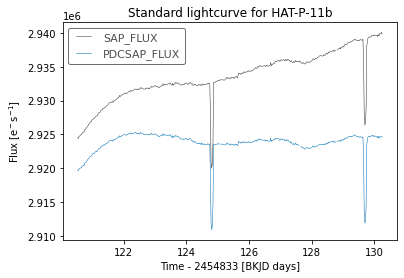

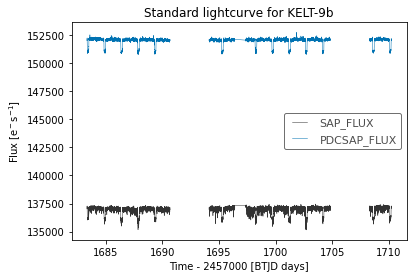

In [15]:
for i in range(len(lcfs)):
    fig, ax = plt.subplots()
    lcfs[i].plot(ax=ax)
    ax.set_title("Standard lightcurve for {0}".format(PLANETS[i]))

## Plot the TESS 2-min data with SAP

Download our planets' pixelfiles so we can see their lightcurves and display the star. We will take the first available quarter of data, but we could take others.

In order to correct the HAT-P-11b data, we need a rectangular image. In its current state, however, the image is circular. So we trim it a bit.

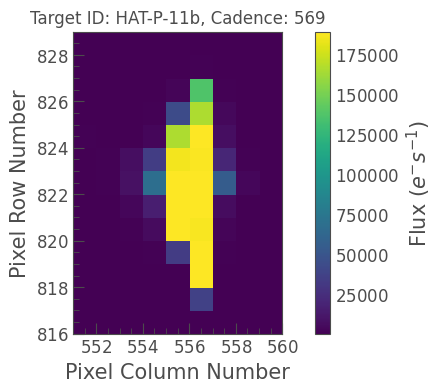

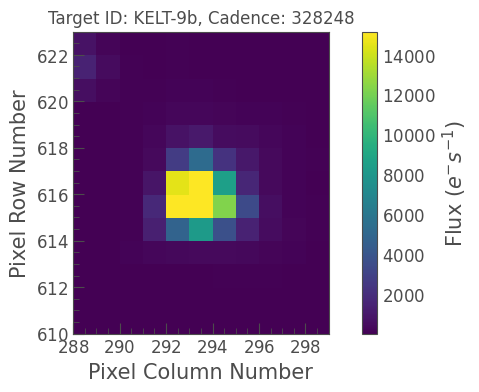

In [16]:
pixelfiles = [lk.search_targetpixelfile(p)[0].download(quality_bitmask='hardest') for p in PLANETS]

# Trim the HAT-P-11b picture
index = PLANETS.index("HAT-P-11b")
pixelfiles[index] = pixelfiles[index].cutout(size=(pixelfiles[index].shape[1]-6, pixelfiles[index].shape[2]-2))

for i in range(len(PLANETS)):
    
    plot = pixelfiles[i].plot(frame=1)
    cadenceIndex = plot.get_title().find(',')
    plot.set_title("Target ID: " + PLANETS[i] + plot.get_title()[cadenceIndex:]);

Now we will get the suggested aperture mask and make sure it is reasonable

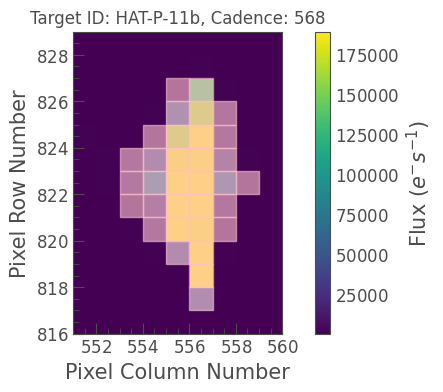

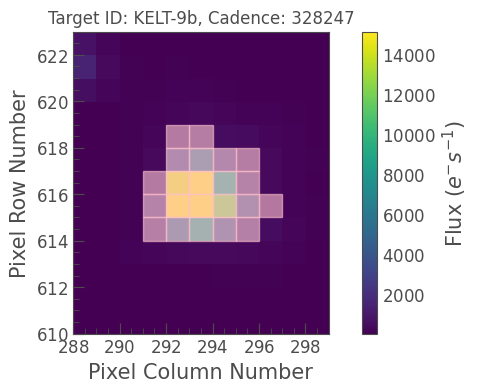

In [27]:
aper = [pf.create_threshold_mask() for pf in pixelfiles];
for i in range(len(PLANETS)):
    p = pixelfiles[i].plot(aperture_mask=aper[i]);
    cadenceIndex = p.get_title().find(',')
    p.set_title("Target ID: " + PLANETS[i] + p.get_title()[cadenceIndex:]);

Now we can access the lightcurves associated with these aperture masks.

In [18]:
lightcurves = [pixelfiles[i].to_lightcurve(aperture_mask=aper[i]).flatten() for i in range(len(PLANETS))];

If we wanted to, we would clean the data. There are a few ways to do this, and the `lightkurve` methods are listed [here](https://docs.lightkurve.org/tutorials/index.html#removing-instrument-noise). I started by removing the background noise from reflected light, but this became a problem because the pixel file for HAT-P-11b is not square, and the algorithm assumes it is square. I have not fixed this problem, so I just flattened the curve instead. Code is below.

In [30]:
correctedLCs = []
CORRECT_MODE = "pca"

if CORRECT_MODE == "pca": #(aperture * TPF + background subtraction + cotrending basis vectors)
    regressors = [pixelfiles[i].flux[:, ~aper[i]] for i in range(len(PLANETS))]# The regressor is the inverse of the aperture

    dms = [lk.DesignMatrix(r, name='regressors').pca(5).append_constant() for r in regressors]
    correctors = [lk.RegressionCorrector(lc) for lc in lightcurves]
    correctedLCs = [correctors[i].correct(dms[i]) for i in range(len(PLANETS))]
    
if CORRECT_MODE == "pld":# Don't know what this is, but I think it's similar to PSF.
    from lightkurve.correctors import TessPLDCorrector
    correctors = [TessPLDCorrector(pf) for pf in pixelfiles]
    correctedLCs = [c.correct() for c in correctors]

Now we will plot our corrected lightcurves.

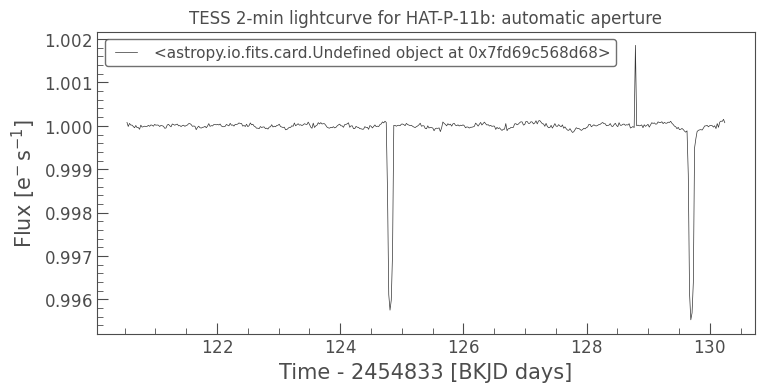

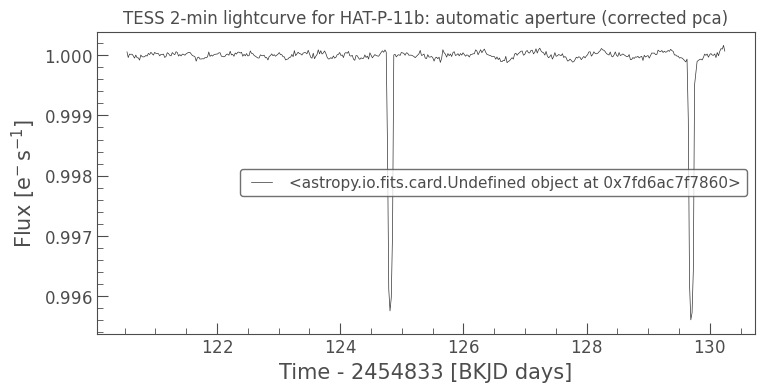

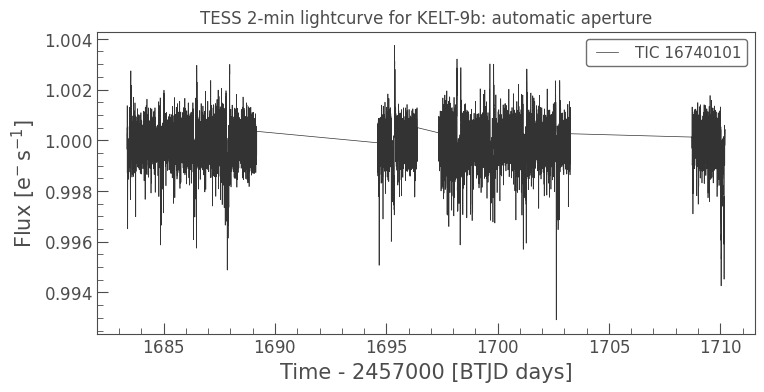

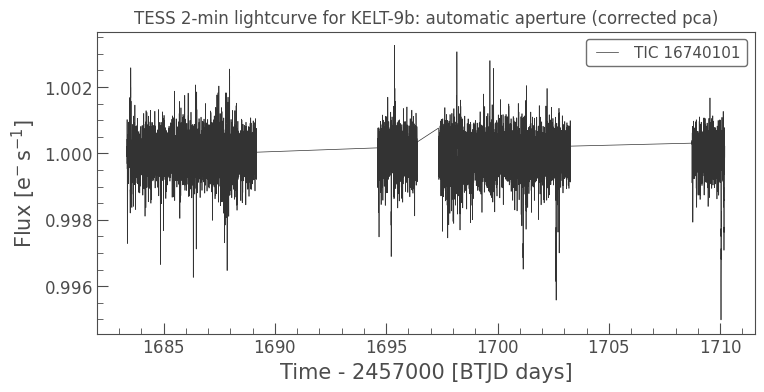

In [31]:
for i in range(len(PLANETS)):
    plot = lightcurves[i].plot();
    plot2 = correctedLCs[i].flatten().plot();
    plot.set_title("TESS 2-min lightcurve for {0}: automatic aperture".format(PLANETS[i]));
    plot2.set_title("TESS 2-min lightcurve for {0}: automatic aperture (corrected {1})".format(PLANETS[i], CORRECT_MODE));

## Plot the TESS 2-min data with a different aperture

We could use a custom aperture if we wanted, but for now I will use the entire window. All we need to do is repeat some of the code from above:

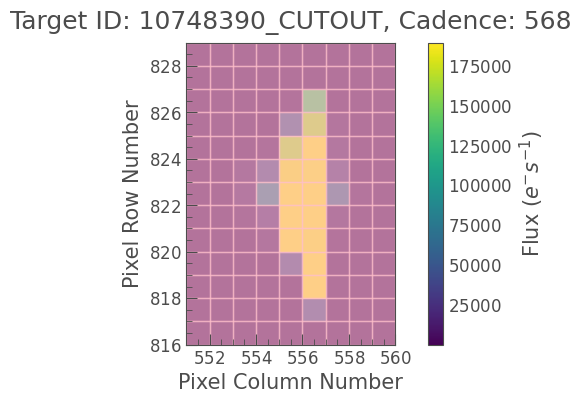

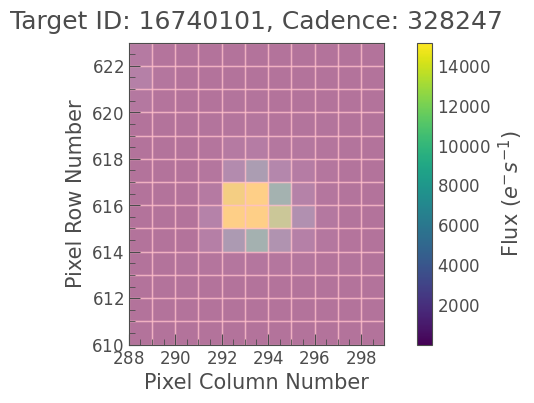

In [21]:
newAper = [np.ones_like(a) for a in aper];
for i in range(len(PLANETS)):
    pixelfiles[i].plot(aperture_mask=newAper[i]);

Now we make and plot the lightcurves:

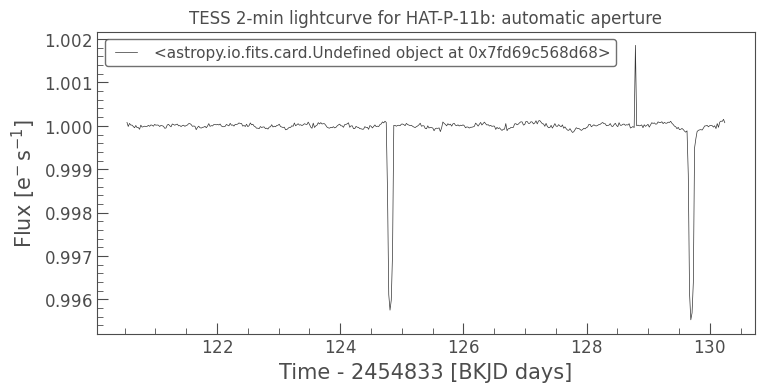

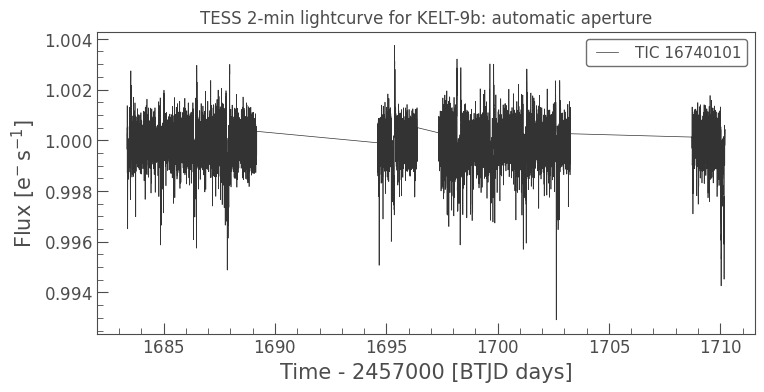

In [22]:
lightcurves = [pixelfiles[i].to_lightcurve(aperture_mask=newAper[i]).flatten() for i in range(len(PLANETS))];

for i in range(len(PLANETS)):
    plot = lightcurves[i].plot();
    plot.set_title("TESS 2-min lightcurve for {0}: automatic aperture".format(PLANETS[i]));

We could have skipped the first step by simply setting the `aperture_mask` flag in `to_lightcurve` equal to `'all'`, but I didn't because I wanted the picture.

There's not much of a difference in the lightcurve, probably because the star is a significant fraction of the image and there are no background stars. But you can tell that the lightcurves made with a bigger aperture are lower quality, probably because of noise from stars and because the data is diluted

## Eleanor lightcurve with 30-min FFI data
I'm using code very similar to the tutorial code in _WASP-100-b-analysis.ipynb_. First, we need to access the planets.

In [2]:
from IPython.display import Image
import eleanor
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord

import warnings
warnings.filterwarnings('ignore')

stars = [eleanor.Source(name=p) for p in PLANETS]

Error initializing plugin EntryPoint(name='Windows (alt)', value='keyrings.alt.Windows', group='keyring.backends').
Traceback (most recent call last):
  File "/home/jtdinsmo/.local/lib/python3.6/site-packages/keyring/backend.py", line 203, in _load_plugins
    init_func = ep.load()
  File "/home/jtdinsmo/.local/lib/python3.6/site-packages/importlib_metadata/__init__.py", line 96, in load
    module = import_module(match.group('module'))
  File "/usr/lib/python3.6/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 994, in _gcd_import
  File "<frozen importlib._bootstrap>", line 971, in _find_and_load
  File "<frozen importlib._bootstrap>", line 955, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 665, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_f

No eleanor postcard has been made for your target (yet). Using TessCut instead.
No eleanor postcard has been made for your target (yet). Using TessCut instead.


Then, we need to get the target data...

In [3]:
data = [eleanor.TargetData(s, height=15, width=15, bkg_size=31, do_psf=True, do_pca=True) for s in stars]

100%|██████████| 1197/1197 [00:19<00:00, 61.10it/s]


... and display the lightcurves. Plotted below are the following:
- Black : the raw light curve (aperture $\times$ TPF + background subtraction)
- Red : the corrected light curve (black light curve + additional corrections)
- Green : the PCA light curve (aperture $\times$ TPF + background subtraction + cotrending basis vectors)
- Blue : the PSF modeled light curve

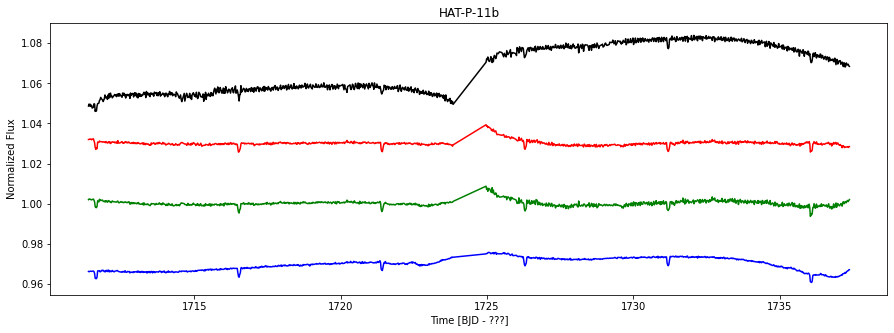

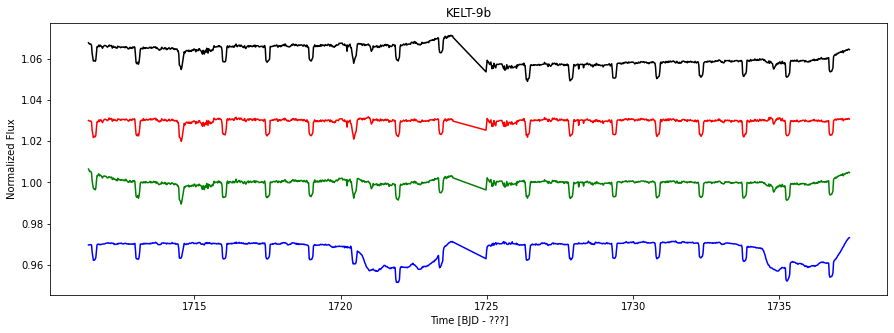

In [4]:
for i in range(len(data)):
    plt.figure(figsize=(15,5))

    q = data[i].quality == 0
    plt.plot(data[i].time[q], data[i].raw_flux[q]/np.nanmedian(data[i].raw_flux[q])+0.06, 'k', label='Raw')
    plt.plot(data[i].time[q], data[i].corr_flux[q]/np.nanmedian(data[i].corr_flux[q]) + 0.03, 'r', label='Corrected')
    plt.plot(data[i].time[q], data[i].pca_flux[q]/np.nanmedian(data[i].pca_flux[q]), 'g', label='PCA')
    plt.plot(data[i].time[q], data[i].psf_flux[q]/np.nanmedian(data[i].psf_flux[q]) - 0.03, 'b', label='PSF')
    plt.ylabel('Normalized Flux')
    plt.xlabel('Time [BJD - ???]')# Used to be BJD - 2457000, but I don't know if that's tutorial-specific
    plt.title(PLANETS[i]);

Maybe we want to choose a custom aperture. We can set it as shown below.

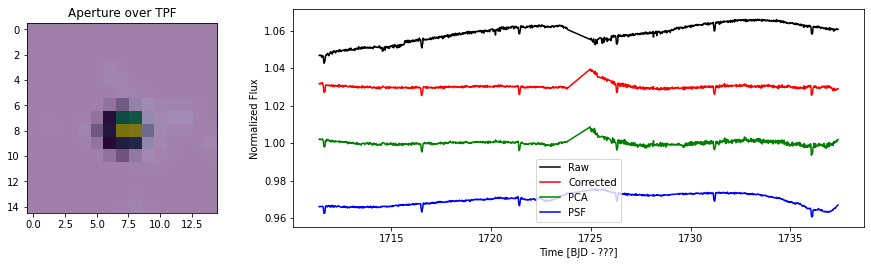

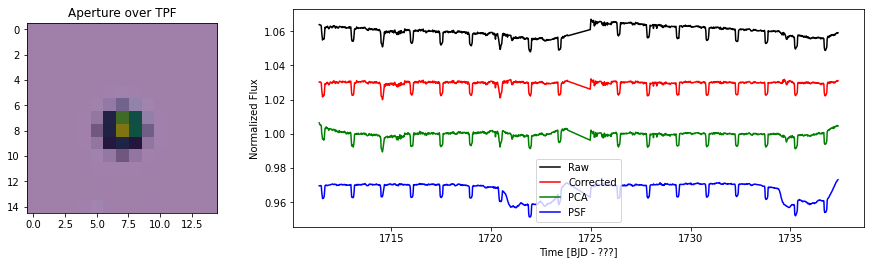

In [12]:
SHAPES = ["circle", "circle"]
RADII = [2, 2]
POSES = [(7, 8), (7, 8)]

for i in range(len(PLANETS)):
    eleanor.TargetData.custom_aperture(data[i], shape=SHAPES[i], r=RADII[i], pos=POSES[i], method='exact')
    eleanor.TargetData.get_lightcurve(data[i])

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
    ax1.imshow(data[i].tpf[0])
    ax1.imshow(data[i].aperture, cmap='Greys', alpha=0.5)
    ax1.set_title('Aperture over TPF')

    #ax2.plot(data[i].time[q], data[i].raw_flux[q]/np.nanmedian(data[i].raw_flux[q]), 'k', label='Raw')
    #ax2.plot(data[i].time[q], data[i].corr_flux[q]/np.nanmedian(data[i].corr_flux[q]) - 0.035, 'r', label='Corrected')
    
    ax2.plot(data[i].time[q], data[i].raw_flux[q]/np.nanmedian(data[i].raw_flux[q])+0.06, 'k', label='Raw')
    ax2.plot(data[i].time[q], data[i].corr_flux[q]/np.nanmedian(data[i].corr_flux[q]) + 0.03, 'r', label='Corrected')
    ax2.plot(data[i].time[q], data[i].pca_flux[q]/np.nanmedian(data[i].pca_flux[q]), 'g', label='PCA')
    ax2.plot(data[i].time[q], data[i].psf_flux[q]/np.nanmedian(data[i].psf_flux[q]) - 0.03, 'b', label='PSF')
    
    ax2.legend()
    ax2.set_xlabel('Time [BJD - ???]')
    ax2.set_ylabel('Normalized Flux');